In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

from utils import *

In [2]:
from unet_model import UNet

In [3]:
class UnetData(torch.utils.data.Dataset):
    def __init__(self, encrpyted, original):
        self.data = encrpyted
        self.targets = original

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item], self.targets[item]

In [6]:
# CIFAR
trainset =  torchvision.datasets.CIFAR10(root='./data/', train=True, download=False)
testset = torchvision.datasets.CIFAR10('./data/', train=True, download=False)
trainset.data = torch.from_numpy(trainset.data.mean(axis=-1)).int()
testset.data = torch.from_numpy(testset.data.mean(axis=-1)).int()

In [4]:
# MNIST
trainset = torchvision.datasets.MNIST('./data/', train=True, download=False)
testset = torchvision.datasets.MNIST('./data/', train=False, download=False)

In [5]:
image_length = len(trainset.data[0].flatten())

In [6]:
# create the key for encryption
x0 = 0.123456789
# alpha = 500
# alpha = 0.95
alpha = 3.601
key = keygen(logistic_map, image_length, x0, alpha)

In [7]:
tr_encrypted =  torch.zeros_like(trainset.data)
tr_targets = torch.zeros_like(trainset.data)
# set out data as encrypted input, decrypted output
for idx, img in enumerate(trainset.data):
    if idx % 1000 == 0:
        print(f"{idx}/{len(trainset.data)}", end="\r", flush=True)
    img_copy = img.clone()
    enc = encrypt(img_copy, key)
    tr_encrypted[idx][:, :] = enc
    tr_targets[idx][:, :] = img_copy
    
# bad normalization but lets see how it works
tr_encrypted = tr_encrypted/255
tr_targets = tr_targets/255

In [8]:
va_encrypted =  torch.zeros_like(testset.data)
va_targets = torch.zeros_like(testset.data)
# set out data as encrypted input, decrypted output
for idx, img in enumerate(testset.data):
    if idx % 1000 == 0:
        print(f"{idx}/{len(testset.data)}", end="\r", flush=True)
    img_copy = img.clone()
    enc = encrypt(img_copy, key)
    va_encrypted[idx][:, :] = enc
    va_targets[idx][:, :] = img_copy
    
# bad normalization but lets see how it works
va_encrypted = va_encrypted/255
va_targets = va_targets/255

In [9]:
train_data = UnetData(tr_encrypted, tr_targets)
tr_data_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

va_data = UnetData(va_encrypted, va_targets)
va_data_loader = DataLoader(
    dataset=va_data,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

In [13]:
iter_train_loss = []

epoch_train_loss = []
val_train_loss = []

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(1, 1)
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
iter_idx = -1
for epoch in range(epochs):
    prefix = "Training Epoch {:3d}: ".format(epoch)
    curr_epoch = []
    for data in tqdm(tr_data_loader, desc=prefix, postfix="loss {:8f}".format(loss)):
        iter_idx += 1
        x, y = data
        x = x.to(device).unsqueeze(1)
        y = y.to(device).unsqueeze(1)
        
        predictions = model(x)
        
        loss = criterion(predictions, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        curr_epoch.append(loss.item())
        
        if iter_idx >= 150:
            assert False
        
    iter_train_loss += curr_epoch
    epoch_train_loss.append(np.mean(curr_epoch))

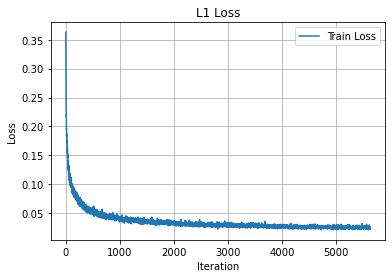

In [14]:
plt.plot(iter_train_loss, label="Train Loss")
plt.title("L1 Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Text(0.5, 1.0, 'Encrypted Image')

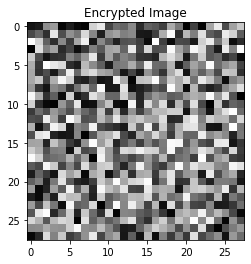

In [17]:
plt.imshow(x[0,0].cpu(), cmap="gray")
plt.title("Encrypted Image")

Text(0.5, 1.0, 'Predicted Image')

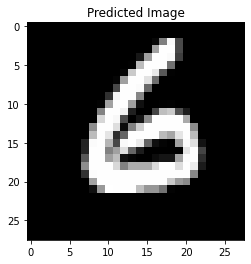

In [25]:
plt.imshow(y[0,0].cpu(), cmap="gray")
plt.title("Predicted Image")

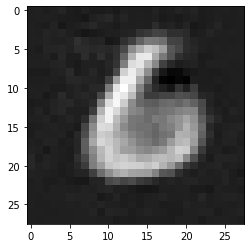

In [24]:
plt.imshow(predictions[0,0].detach().cpu().numpy(), cmap="gray")

In [18]:
va_loss = []
for data in tqdm(va_data_loader, desc=prefix):
    with torch.no_grad():
        x, y = data
        x = x.to(device).unsqueeze(1)
        y = y.to(device).unsqueeze(1)

        predictions = model(x)

        loss = criterion(predictions, y)
        va_loss.append(loss.item())
    av_va_loss = np.mean(va_loss)

Training Epoch   2: 100%|████████████████████████████████████████████████████████████████████| 313/313 [00:04<00:00, 76.78it/s]


In [19]:
av_va_loss

0.02450551060489572

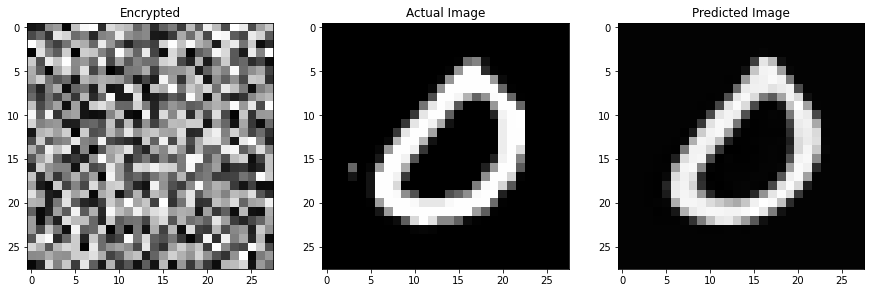

In [25]:
fig = plt.figure(figsize=(15,5))
example = 0

plt.subplot(1, 3, 1)
plt.title("Encrypted")
plt.imshow(x[example,0].cpu(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Actual Image")
plt.imshow(y[example,0].cpu(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Image")
plt.imshow(predictions[example,0].detach().cpu().numpy(), cmap='gray')

plt.show()

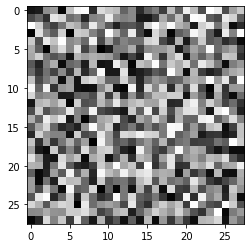

In [21]:
plt.imshow(x[0,0].cpu(), cmap='gray')

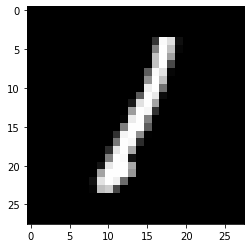

In [22]:
plt.imshow(y[6,0].cpu(), cmap='gray')

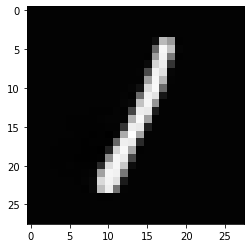

In [23]:
plt.imshow(predictions[6,0].detach().cpu().numpy(), cmap='gray')